Cloning into 'rnn_csv_file'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 27.69 KiB | 3.46 MiB/s, done.
         3
0    60905
1    57309
2    58310
3    58936
4    63471
..     ...
357  63177
358  64677
359  62941
360  63140
361  67701

[362 rows x 1 columns]
289 73
(286, 3) (286,)
(70, 3) (70,)
(286, 1, 3)
(70, 1, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5)                 45        
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
________________________

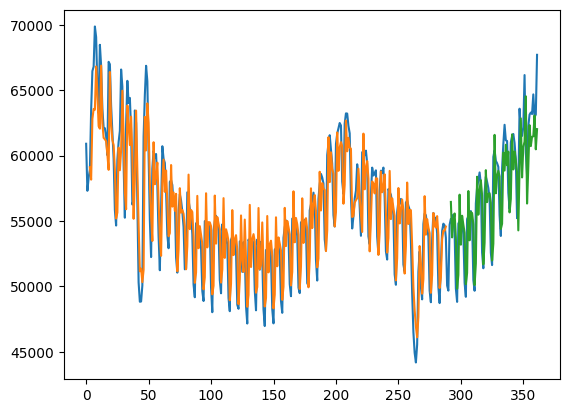

In [ ]:
from keras.engine.training import optimizer
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

#데이터 가져오기
!git clone https://github.com/half7840/rnn_csv_file
dataframe = read_csv('/content/rnn_csv_file/power_daily_1year_sd.csv', usecols=[3], engine='python', skipfooter=3)
print(dataframe)
dataset = dataframe.values
dataset = dataset.astype('float32')

#데이터 정규화 및 분류
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
train_data, test_data = train_test_split(scaled_dataset, test_size=0.2, shuffle=False)
print(len(train_data), len(test_data))

#데이터 형태 변경
def create_dataset(dataset, look_back):
  x_data = []
  y_data = []
  for i in range(len(dataset)-look_back):
    data = dataset[i:(i+look_back), 0]
    x_data.append(data)
    y_data.append(dataset[i+look_back, 0])
  return np.array(x_data), np.array(y_data)

#입력 데이터 생성
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

#모델에 적합하게 형태 변경
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

#인공지능 모델 설계
model = Sequential()
model.add(SimpleRNN(5, input_shape=(1, look_back)))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='adam')
model.summary()

#모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

#데이터 예측
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
TrainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([y_train])
TestPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([y_test])
print(trainPredict)

#모델 정확도
trainScore = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:,0]))
print('Train Score : %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:,0]))
print('Test Score : %.2f RMSE' % (testScore))

#결과 그래프화
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(TrainPredict)+look_back, :] = TrainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(TrainPredict)+(look_back)*2:len(dataset), :] = TestPredict
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()